<a href="https://colab.research.google.com/github/dineshsainii/computer_vision/blob/main/DeepLearning_FeedForward_NN_Jovian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Creating a deep neural network with hidden layers
*   Using a non-linear activation function
*   Using a GPU (when available) to speed up training
*   Experimenting with hyperparameters to improve the model

In [15]:
#Imports
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [16]:
# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [17]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

image.shape: torch.Size([1, 28, 28])
Label: 5


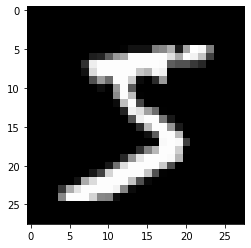

In [18]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image[0], cmap='gray')
print('Label:', label)

In [19]:
val_size = 10000
train_size = len(dataset)-val_size
train_ds, val_ds = random_split(dataset,[train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [20]:
batch_size = 128

In [21]:
#PyTorch data loaders for training and validation.
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


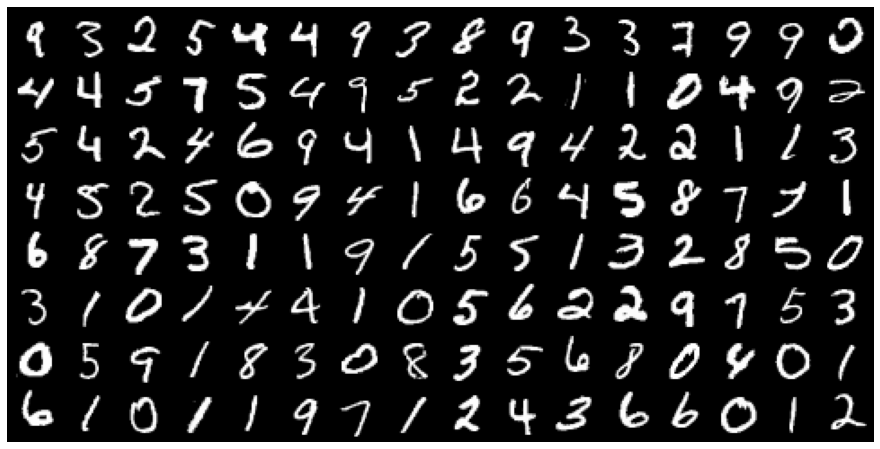

In [22]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [23]:
# test = np.ones([7,1,3,3],dtype='int')
# print(test.shape)
# test1 = test.reshape(-1,9)
# print(test1.shape)

In [24]:
for images,labels in train_loader:
  print('images.shape', images.shape)
  inputs = images.reshape(-1,784)
  print('inputs.shape',inputs.shape)
  break

images.shape torch.Size([128, 1, 28, 28])
inputs.shape torch.Size([128, 784])


In [25]:
input_size = inputs.shape[-1]
print(input_size)
hidden_size = 32

784


In [26]:
#A nn.Linear object, which will serve as our hidden layer
layer1 = nn.Linear(input_size,hidden_size)

In [27]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape : ',layer1_outputs.shape)

layer1_outputs.shape :  torch.Size([128, 32])


In [28]:
#Applying ReLU function for capturing non-linearity
relu_outputs = F.relu(layer1_outputs)
print('min_layer1_outputs : ', torch.min(layer1_outputs).item())
print('min_relu_outputs : ', torch.min(relu_outputs).item())

min_layer1_outputs :  -0.9286470413208008
min_relu_outputs :  0.0


In [29]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [30]:
layer2_outputs = layer2(relu_outputs)

In [31]:
print(layer2_outputs.shape)

torch.Size([128, 10])


In [32]:
class MnistModel(nn.Module):
  """Feedfoward neural network with 1 hidden layer"""
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    #Hidden Layer
    self.linear1 = nn.Linear(in_size, hidden_size)
    #Output Layer
    self.linear2 = nn.Linear(hidden_size, out_size)
  
  def forward(self, xb):
    # Flatten the image tensors
    xb = xb.view(xb.size(0), -1)#same as xb.reshape but saves memory
    # Get intermediate outputs using hidden layer
    out = self.linear1(xb)
    #Relu activation function
    out = F.relu(out)
    #output layer
    out = self.linear2(out)
    return out
  
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out, labels)
    return {'val_loss':loss, 'val_acc':acc}
  
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() #Combine Losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean() #combine accuracies
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
  
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [33]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [34]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [35]:
model = MnistModel(in_size=input_size, hidden_size=32, out_size=num_classes)


In [36]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [37]:
for images, labels in train_loader:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('loss ::', loss.item())
  break

print('outputs.shape :: ',outputs.shape)
print('sample outputs :\n ',outputs[:2].data)

loss :: 2.3070895671844482
outputs.shape ::  torch.Size([128, 10])
sample outputs :
  tensor([[-0.1028, -0.1090,  0.0505, -0.0859,  0.1542, -0.1733,  0.1789, -0.0795,
         -0.0291,  0.0698],
        [-0.1359, -0.1494,  0.0329, -0.0539,  0.0795, -0.1088,  0.1679, -0.0178,
          0.0070,  0.0383]])


In [38]:
torch.cuda.is_available()

True

In [39]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cuda')

In [40]:
device = get_default_device()
device

device(type='cuda')

In [41]:
#move data and model to a chosen device
def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)
for images, labels in train_loader:
  print(images.shape)
  images = to_device(images, device)
  print(images.device)
  break

torch.Size([128, 1, 28, 28])
cuda:0


In [42]:
class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)
  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [43]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [44]:
for xb, yb in val_loader:
  print('xb.device', xb.device)
  print('yb', yb)
  break

xb.device cuda:0
yb tensor([4, 4, 9, 8, 6, 0, 0, 4, 6, 3, 4, 1, 6, 0, 3, 9, 3, 1, 1, 3, 7, 9, 6, 4,
        6, 8, 2, 5, 9, 5, 9, 1, 2, 9, 9, 5, 8, 0, 0, 2, 5, 4, 9, 1, 4, 6, 7, 0,
        1, 0, 6, 0, 1, 4, 4, 2, 7, 7, 8, 4, 4, 6, 8, 7, 3, 0, 1, 7, 1, 3, 1, 8,
        4, 4, 5, 0, 3, 5, 9, 6, 5, 6, 9, 3, 4, 5, 0, 8, 3, 8, 3, 8, 6, 4, 4, 6,
        1, 0, 1, 8, 0, 9, 6, 4, 3, 8, 6, 6, 3, 1, 2, 8, 1, 4, 2, 8, 3, 1, 8, 1,
        0, 7, 5, 0, 3, 7, 7, 0, 6, 7, 9, 0, 8, 9, 5, 4, 6, 9, 2, 3, 4, 4, 1, 6,
        4, 3, 8, 1, 4, 8, 6, 9, 1, 4, 7, 0, 4, 4, 6, 8, 2, 6, 3, 2, 7, 1, 3, 0,
        6, 7, 9, 9, 2, 7, 4, 4, 3, 3, 9, 5, 2, 6, 1, 7, 7, 8, 9, 1, 1, 6, 0, 7,
        1, 6, 1, 5, 8, 6, 4, 9, 1, 6, 0, 9, 3, 0, 2, 5, 1, 1, 0, 4, 2, 1, 6, 3,
        1, 3, 0, 9, 2, 7, 7, 8, 7, 4, 2, 9, 1, 3, 0, 8, 6, 6, 4, 9, 5, 3, 7, 2,
        7, 7, 3, 1, 1, 9, 6, 4, 3, 3, 6, 5, 4, 8, 7, 0], device='cuda:0')


In [52]:
def evaluate(model, val_loader):
  """Evaluate the model's performance on the validation set"""
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  """Train the model using gradient descent"""
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    #Training Phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Validation phase
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history



In [75]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [54]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.1162109375, 'val_loss': 2.309335470199585}]

In [83]:
history += fit(5, 0.5, model, train_loader,val_loader)

Epoch [0], val_loss: 0.1742, val_acc: 0.9499
Epoch [1], val_loss: 0.1508, val_acc: 0.9533
Epoch [2], val_loss: 0.1417, val_acc: 0.9584
Epoch [3], val_loss: 0.1503, val_acc: 0.9524
Epoch [4], val_loss: 0.1406, val_acc: 0.9574


In [84]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1099, val_acc: 0.9678
Epoch [1], val_loss: 0.1107, val_acc: 0.9672
Epoch [2], val_loss: 0.1102, val_acc: 0.9681
Epoch [3], val_loss: 0.1078, val_acc: 0.9675
Epoch [4], val_loss: 0.1086, val_acc: 0.9685


In [61]:
print( list(x['val_loss'] for x in history))

[2.309335470199585, 0.2779889702796936, 0.20738470554351807, 0.1516488641500473, 0.14569024741649628, 0.14750222861766815, 0.1166357547044754, 0.11566495895385742, 0.11496236175298691, 0.11413808912038803, 0.11228561401367188]


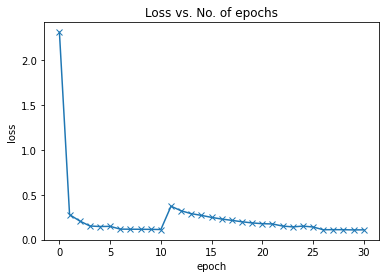

In [85]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

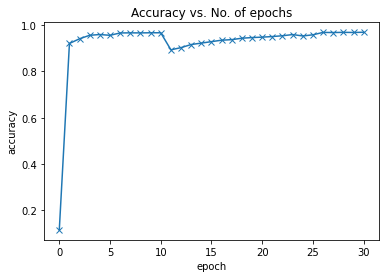

In [86]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

#Testing with individual images

In [64]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [76]:
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0),device)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return preds[0].item()


Lable :  7 Predicted : 7


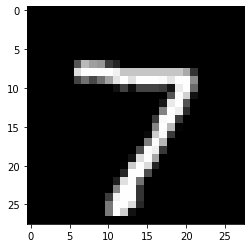

In [88]:
img, label = test_dataset[0]
# print(img)
plt.imshow(img[0],cmap='gray')
print('Lable : ', label, 'Predicted :', predict_image(img, model))

In [89]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.970507800579071, 'val_loss': 0.10005904734134674}